In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from numpy import sort
from sklearn.feature_selection import SelectFromModel


# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [190]:
df=pd.read_csv('adult_income.csv')
df.drop_duplicates(keep='first',inplace=True)
df.drop(index=df[(df[' Work-class']==' ?')|(df[' Occupation']==' ?') |(df[' Native-country']==' ?')].index,inplace=True)
df['income']=df[' Income'].map(lambda x: 0 if x ==' <=50K' else 1)
df.drop(" Income",axis=1,inplace=True)
print(df.shape)

(30139, 15)


In [191]:
# One-hot Encoding for categorical data (native-country 0 for US,1 for others)
df=pd.get_dummies(df, columns=[' Work-class'],drop_first=False)
df=pd.get_dummies(df, columns=[' Marital-status'],drop_first=False)
df=pd.get_dummies(df, columns=[' Occupation'],drop_first=False)
df=pd.get_dummies(df, columns=[' Relationship'],drop_first=False)
df=pd.get_dummies(df, columns=[' Race'],drop_first=False)
df=pd.get_dummies(df, columns=[' Sex'],drop_first=False)
df[' Native-country']=df[' Native-country'].map(lambda x: 0 if x ==' United-States' else 1)

In [192]:
# Eduction and Eduction_num are essentially duplicate
df.drop(' Education', axis=1, inplace=True)

In [193]:
print(df.shape)
df['Capital'] = df[' Capital-gain'] + df[' Capital-loss']
df.drop(' Capital-gain', axis=1, inplace=True)
df.drop(' Capital-loss', axis=1, inplace=True)
print(df.shape)

(30139, 49)
(30139, 48)


In [194]:
index=df[df['Capital']>=10000].index
df.drop(index=index,inplace=True)

In [195]:
df.shape

(29407, 48)

In [196]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df[[' fnlwgt','Capital',' Hours-per-week']])
df[[' fnlwgt','Capital',' Hours-per-week']] = scaler.transform(df[[' fnlwgt','Capital',' Hours-per-week']])

In [197]:
df.shape

(29407, 48)

## feature selection

In [212]:
dataX=df.drop('income',axis=1)
dataY=df['income']

In [199]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
importance_f=f_classif(dataX, dataY) 
feature_importance=pd.DataFrame(importance_f,columns=dataX.columns,index=['f-statistics','p-value']).T.sort_values(by='f-statistics',ascending=False)

In [200]:
feature_importance=feature_importance.reset_index().rename(columns={'index':'feature'})

In [201]:
feature_importance

,feature,f-statistics,p-value
0,Marital-status_ Married-civ-spouse,7401.515,0.000
1,Relationship_ Husband,5721.788,0.000
2,Marital-status_ Never-married,3318.909,0.000
3,Education-num,3158.748,0.000
4,Capital,2373.282,0.000
5,Age,1608.196,0.000
6,Relationship_ Own-child,1488.501,0.000
7,Hours-per-week,1455.586,0.000
8,Sex_ Female,1402.533,0.000
9,Sex_ Male,1402.533,0.000


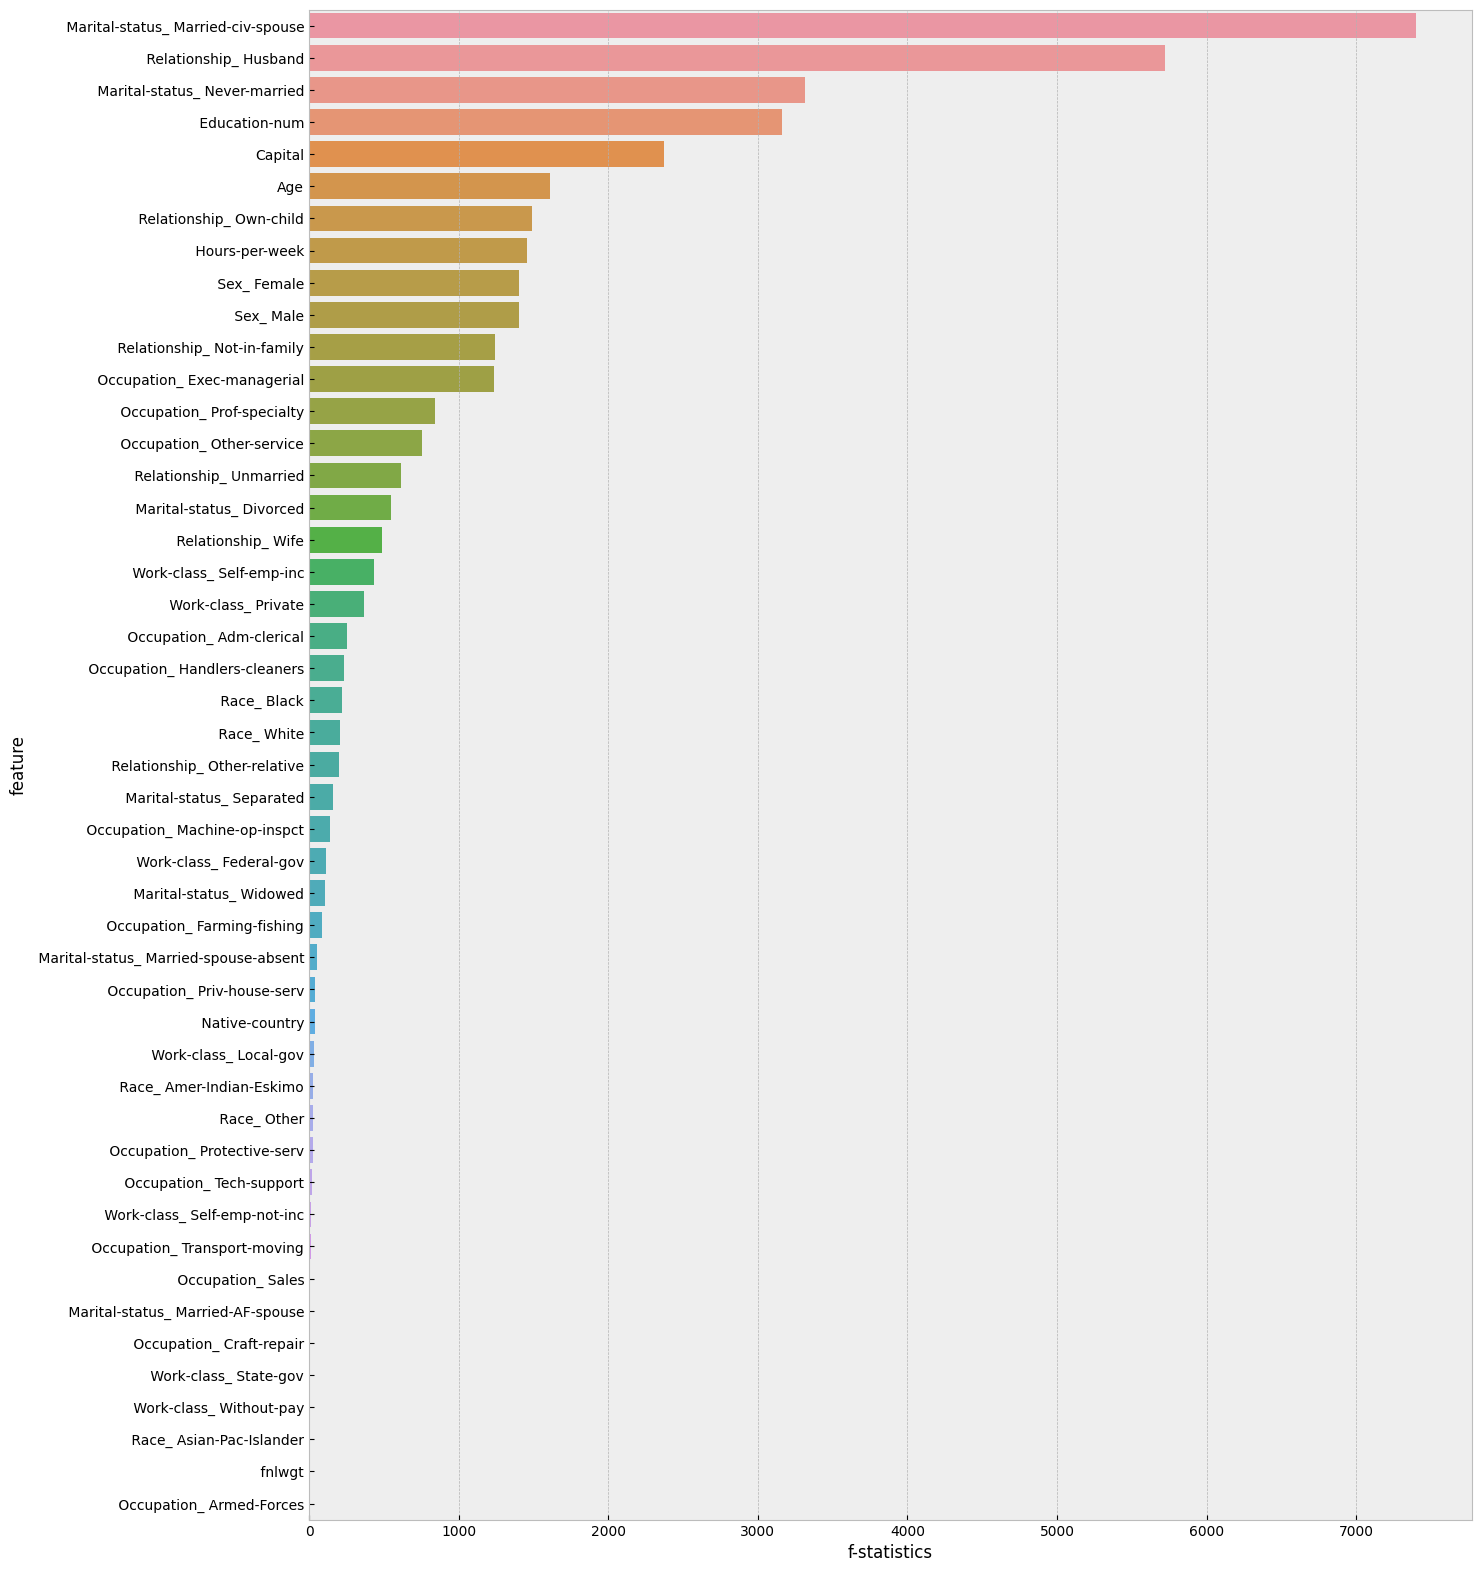

In [204]:
plt.figure(figsize=(15,20),dpi=100)
sns.barplot(y=feature_importance.feature,x=feature_importance['f-statistics'])
plt.show()

In [205]:
# maybe choose the first 28 features
chosen=list(feature_importance.feature[0:29].values)

# PCA after feature selection

In [206]:
dataX_pca = dataX[chosen].copy()
variance_explained = 0.95
pca = PCA(variance_explained)
principalComponents = pca.fit(dataX_pca)
print(principalComponents.explained_variance_ratio_)
principalComponents = principalComponents.transform(dataX_pca)

[0.93957867 0.03522914]


In [207]:
principalDf = pd.DataFrame(data = principalComponents)
# # Concatenate dataframe with 'shares_bin2' column
df_pca = pd.merge(principalDf, df[['income']].reset_index(drop='index'),right_index=True,left_index=True)
df_pca

,0,1,income
0,0.775,-2.983,0
1,11.786,-2.725,0
2,-0.245,1.094,0
3,14.754,3.192,0
4,-10.211,-3.013,0
...,...,...,...
29402,-16.252,-0.031,0
29403,-11.219,-1.976,0
29404,1.775,1.096,1
29405,19.741,1.257,0


In [208]:
n_pcs=pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names  = chosen
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
pd.DataFrame(dic.items())

,0,1
0,PC0,Age
1,PC1,Education-num


# PCA with no feature selection

In [213]:
dataX_pca_nofs = dataX.copy()
variance_explained = 0.95
pca = PCA(variance_explained)
principalComponents = pca.fit(dataX_pca_nofs)
print(principalComponents.explained_variance_ratio_)
principalComponents = principalComponents.transform(dataX_pca_nofs)

[0.93122718 0.03496091]


In [210]:
principalDf = pd.DataFrame(data = principalComponents)
# # Concatenate dataframe with 'shares_bin2' column
df_pca_nofs = pd.merge(principalDf, df[['income']].reset_index(drop='index'),right_index=True,left_index=True)
df_pca_nofs

,0,1,income
0,0.781,-3.015,0
1,11.794,-2.747,0
2,-0.247,1.095,0
3,14.751,3.198,0
4,-10.220,-2.971,0
...,...,...,...
29402,-16.259,-0.012,0
29403,-11.223,-1.970,0
29404,1.777,1.086,1
29405,19.742,1.248,0


In [211]:
n_pcs=pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names  = chosen
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
pd.DataFrame(dic.items())


,0,1
0,PC0,Marital-status_ Married-civ-spouse
1,PC1,Marital-status_ Never-married


## Comparison

In [104]:
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition, ensemble
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import xgboost
import lightgbm as lgb


In [464]:
def model(X_train, X_test, y_train, y_test):
    models = {'knn': KNeighborsClassifier(),
            'lr':linear_model.LogisticRegression(random_state=123),
            'rf':ensemble.RandomForestClassifier(random_state=123),
            'xgboost':xgboost.XGBClassifier(random_state=123),
            'lighGBM':lgb.LGBMClassifier(random_state=123)
            }

    y_predicts = pd.DataFrame()
    for name, model in models.items():
        clf = model.fit(X_train, y_train)
        y_train_pred = clf.predict_proba(X_train)
        auc = metrics.roc_auc_score(y_train, y_train_pred[:,1])
        print('Model: {} | train AUC: {:.4f}'.format(name, auc))
        y_test_pred = clf.predict_proba(X_test) 
        auc_test = metrics.roc_auc_score(y_test, y_test_pred[:,1])
        print('Test: Model: {} | Test AUC: {:.4f}'.format(name, auc_test))
        y_predicts.loc[name,'train AUC']=auc
        y_predicts.loc[name,'test AUC']=auc_test
    return y_predicts

In [465]:
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY,
                                                    stratify=dataY, 
                                                  random_state=2017, 
                                                  test_size=0.3, shuffle=True)

In [466]:
result_no=model(x_train, x_test, y_train, y_test)

Model: knn | train AUC: 0.9378
Test: Model: knn | Test AUC: 0.8463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: lr | train AUC: 0.8947
Test: Model: lr | Test AUC: 0.8928
Model: rf | train AUC: 1.0000
Test: Model: rf | Test AUC: 0.8903


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: xgboost | train AUC: 0.9628
Test: Model: xgboost | Test AUC: 0.9157


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: lighGBM | train AUC: 0.9458
Test: Model: lighGBM | Test AUC: 0.9181


In [327]:
x_train_fs, x_test_fs, y_train_fs, y_test_fs = train_test_split(dataX[chosen], dataY,
                                                    stratify=dataY, 
                                                  random_state=2017, 
                                                  test_size=0.3, shuffle=True)

In [467]:
result_fs=model(x_train_fs, x_test_fs, y_train_fs, y_test_fs)

Model: knn | train AUC: 0.9352
Test: Model: knn | Test AUC: 0.8396


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: lr | train AUC: 0.8921
Test: Model: lr | Test AUC: 0.8910
Model: rf | train AUC: 0.9952
Test: Model: rf | Test AUC: 0.8758


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: xgboost | train AUC: 0.9495
Test: Model: xgboost | Test AUC: 0.9130


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: lighGBM | train AUC: 0.9388
Test: Model: lighGBM | Test AUC: 0.9172


In [329]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(df_pca.drop('income',axis=1), df_pca['income'],
                                                    stratify=df_pca['income'], 
                                                  random_state=2017, 
                                                  test_size=0.3, shuffle=True)

In [468]:
result_fs_pca=model(x_train_pca, x_test_pca, y_train_pca, y_test_pca)

Model: knn | train AUC: 0.9172
Test: Model: knn | Test AUC: 0.7996
Model: lr | train AUC: 0.7729
Test: Model: lr | Test AUC: 0.7643
Model: rf | train AUC: 0.9947
Test: Model: rf | Test AUC: 0.8250


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: xgboost | train AUC: 0.9237
Test: Model: xgboost | Test AUC: 0.8536


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: lighGBM | train AUC: 0.8870
Test: Model: lighGBM | Test AUC: 0.8518


In [331]:
x_train_pca_nofs, x_test_pca_nofs, y_train_pca_nofs, y_test_pca_nofs = train_test_split(df_pca_nofs.drop('income',axis=1), df_pca_nofs['income'],
                                                    stratify=df_pca_nofs['income'], 
                                                  random_state=2017, 
                                                  test_size=0.3, shuffle=True)

In [469]:
result_pca=model(x_train_pca_nofs, x_test_pca_nofs, y_train_pca_nofs, y_test_pca_nofs)

Model: knn | train AUC: 0.9167
Test: Model: knn | Test AUC: 0.7934
Model: lr | train AUC: 0.7727
Test: Model: lr | Test AUC: 0.7641
Model: rf | train AUC: 1.0000
Test: Model: rf | Test AUC: 0.8195


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: xgboost | train AUC: 0.9228
Test: Model: xgboost | Test AUC: 0.8427


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: lighGBM | train AUC: 0.8804
Test: Model: lighGBM | Test AUC: 0.8444


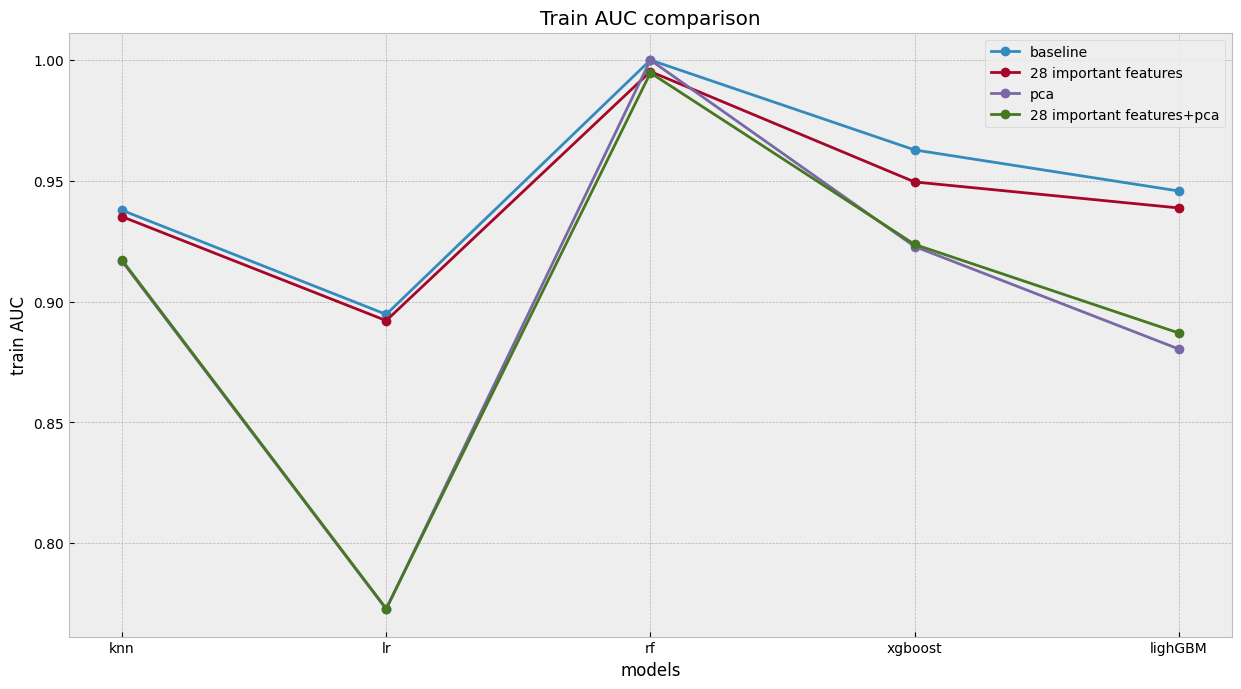

In [470]:
plt.figure(figsize=(15,8),dpi=100)
plt.plot(result_no['train AUC'],marker='o',label='baseline')
plt.plot(result_fs['train AUC'],marker='o',label='28 important features')
plt.plot(result_pca['train AUC'],marker='o',label='pca')
plt.plot(result_fs_pca['train AUC'],marker='o',label='28 important features+pca')
plt.legend(loc='best')
plt.ylabel('train AUC')
plt.xlabel('models')
plt.title('Train AUC comparison')
plt.show()

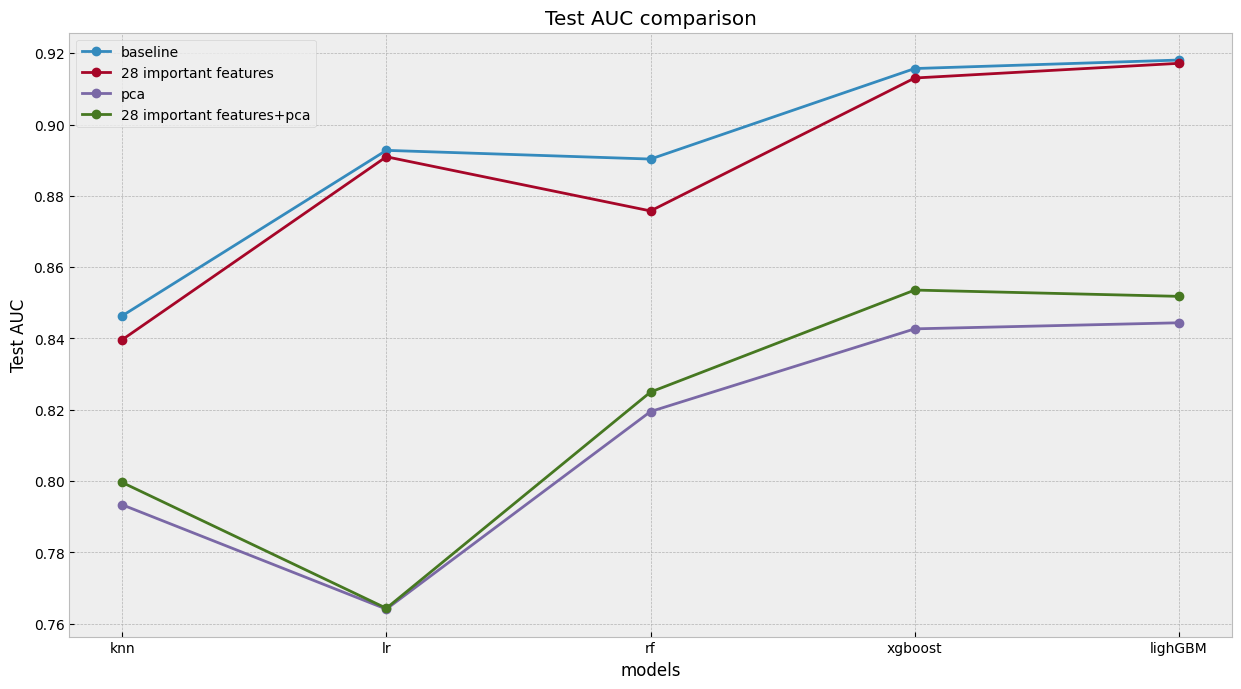

In [471]:
plt.figure(figsize=(15,8),dpi=100)
plt.plot(result_no['test AUC'],marker='o',label='baseline')
plt.plot(result_fs['test AUC'],marker='o',label='28 important features')
plt.plot(result_pca['test AUC'],marker='o',label='pca')
plt.plot(result_fs_pca['test AUC'],marker='o',label='28 important features+pca')
plt.legend(loc='best')
plt.ylabel('Test AUC')
plt.xlabel('models')
plt.title('Test AUC comparison')
plt.show()

In [236]:
# select random forest and xgboost, light GBM

# Model building

## Find suitable methods to deal with imbalanced data


In [339]:
X=df.drop('income',axis=1)
y=df['income']

In [473]:
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE
# Apply the random under-sampling
rus = RandomUnderSampler()
X_RUS, y_RUS = rus.fit_resample(X, y)
# Apply the random over-sampling
ros = RandomOverSampler()
X_ROS, y_ROS = ros.fit_resample(X, y)
# Apply regular SMOTE
sm = SMOTE()
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)

In [474]:
X_RUS_train, X_RUS_test, y_RUS_train, y_RUS_test = train_test_split(X_RUS, y_RUS, test_size=0.3, random_state=2017)
X_ROS_train, X_ROS_test, y_ROS_train, y_ROS_test = train_test_split(X_ROS, y_ROS, test_size=0.3, random_state=2017)
X_SMOTE_train, X_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.3, random_state=2017)

In [475]:
clf = lgb.LGBMClassifier(objective='binary',random_state=123)
clf_rus = clf.fit(X_RUS_train, y_RUS_train)
clf_ros = clf.fit(X_ROS_train, y_ROS_train) 
clf_smote = clf.fit(X_SMOTE_train, y_SMOTE_train)
# Evaluate model performance
print ("\nRUS - Train AUC : ",metrics.roc_auc_score(y_RUS_train, clf.predict_proba(X_RUS_train)[:,1]))
print ("RUS - Test AUC : ",metrics.roc_auc_score(y_RUS_test, clf.predict_proba(X_RUS_test)[:,1]))
print ("\nROS - Train AUC : ",metrics.roc_auc_score(y_ROS_train, clf.predict_proba(X_ROS_train)[:,1]))
print ("ROS - Test AUC : ",metrics.roc_auc_score(y_ROS_test, clf.predict_proba(X_ROS_test)[:,1]))
print ("\nSMOTE - Train AUC : ",metrics.roc_auc_score(y_SMOTE_train, clf.predict_proba(X_SMOTE_train)[:,1]))
print ("SMOTE - Test AUC : ",metrics.roc_auc_score(y_SMOTE_test, clf.predict_proba(X_SMOTE_test)[:,1]))


RUS - Train AUC :  0.9267501828254847
RUS - Test AUC :  0.9211062370455572

ROS - Train AUC :  0.9287443289485932
ROS - Test AUC :  0.9220175539737682

SMOTE - Train AUC :  0.9713159546578004
SMOTE - Test AUC :  0.9664389092746485


In [669]:
clf = linear_model.LogisticRegression(random_state=123)
clf_rus = clf.fit(X_RUS_train, y_RUS_train)
clf_ros = clf.fit(X_ROS_train, y_ROS_train) 
clf_smote = clf.fit(X_SMOTE_train, y_SMOTE_train)
# Evaluate model performance
print ("\nRUS - Train AUC : ",metrics.roc_auc_score(y_RUS_train, clf.predict_proba(X_RUS_train)[:,1]))
print ("RUS - Test AUC : ",metrics.roc_auc_score(y_RUS_test, clf.predict_proba(X_RUS_test)[:,1]))
print ("\nROS - Train AUC : ",metrics.roc_auc_score(y_ROS_train, clf.predict_proba(X_ROS_train)[:,1]))
print ("ROS - Test AUC : ",metrics.roc_auc_score(y_ROS_test, clf.predict_proba(X_ROS_test)[:,1]))
print ("\nSMOTE - Train AUC : ",metrics.roc_auc_score(y_SMOTE_train, clf.predict_proba(X_SMOTE_train)[:,1]))
print ("SMOTE - Test AUC : ",metrics.roc_auc_score(y_SMOTE_test, clf.predict_proba(X_SMOTE_test)[:,1]))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


RUS - Train AUC :  0.8875207091412741
RUS - Test AUC :  0.877338071877135

ROS - Train AUC :  0.8851122102349254
ROS - Test AUC :  0.8879110745159042

SMOTE - Train AUC :  0.9361338911096526
SMOTE - Test AUC :  0.9346778814762605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [479]:
clf = XGBClassifier(random_state=123)
clf_rus = clf.fit(X_RUS_train, y_RUS_train)
clf_ros = clf.fit(X_ROS_train, y_ROS_train) 
clf_smote = clf.fit(X_SMOTE_train, y_SMOTE_train)
# Evaluate model performance
print ("\nRUS - Train AUC : ",metrics.roc_auc_score(y_RUS_train, clf.predict_proba(X_RUS_train)[:,1]))
print ("RUS - Test AUC : ",metrics.roc_auc_score(y_RUS_test, clf.predict_proba(X_RUS_test)[:,1]))
print ("\nROS - Train AUC : ",metrics.roc_auc_score(y_ROS_train, clf.predict_proba(X_ROS_train)[:,1]))
print ("ROS - Test AUC : ",metrics.roc_auc_score(y_ROS_test, clf.predict_proba(X_ROS_test)[:,1]))
print ("\nSMOTE - Train AUC : ",metrics.roc_auc_score(y_SMOTE_train, clf.predict_proba(X_SMOTE_train)[:,1]))
print ("SMOTE - Test AUC : ",metrics.roc_auc_score(y_SMOTE_test, clf.predict_proba(X_SMOTE_test)[:,1]))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



RUS - Train AUC :  0.9416991468144045
RUS - Test AUC :  0.9396031067503985


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



ROS - Train AUC :  0.9482962622337356
ROS - Test AUC :  0.9270879516144198


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



SMOTE - Train AUC :  0.9811065367286692
SMOTE - Test AUC :  0.9660262794986427


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [249]:
# select SMOTE


In [678]:
def confusion(model, X_test, y_test):
    plt.figure(figsize=(15,10),dpi=200)
    metrics.plot_confusion_matrix(model, X_test, y_test,
                                  display_labels=np.unique(y_test),
                                  #include_values=False,
                                  values_format = 'd',
                                  cmap=plt.cm.Blues)
    plt.show()

In [487]:
def report(model,X_test,y_test):
    roc_auc_score = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    accuracy_score = metrics.accuracy_score(y_test, model.predict(X_test))
    f1_score = metrics.f1_score(y_test, model.predict(X_test), average=None)
    precision_score = metrics.precision_score(y_test,model.predict(X_test), average=None)
    print('ROC AUC score:', roc_auc_score)
    print('Accuracy score:', accuracy_score)
    print('F1 score:', f1_score)
    print('Precision score:', precision_score)

    print("Classification report for classifier %s:\n%s\n"
    % (model, metrics.classification_report(y_test, model.predict(X_test))))

In [481]:
def feature_importance(model):

    df_importance = pd.DataFrame()
    df_importance['importance'] = model.feature_importances_
    df_importance['features'] = df.drop('income',axis=1).columns
    df_importance = df_importance.sort_values(by='importance', ascending=False) 
    df_importance = df_importance.reset_index(drop=True)
    
    return df_importance

## LightGBM

In [484]:
# use SMOTE only for train dataset
sm_new=SMOTE()
X_SMOTE_train, y_SMOTE_train = sm_new.fit_resample(x_train, y_train)
print(y_SMOTE_train.value_counts())
print(y_test.value_counts())

0    15834
1    15834
Name: income, dtype: int64
0    6787
1    2036
Name: income, dtype: int64


In [485]:
model_lightGBM = lgb.LGBMClassifier(random_state=123)
model_lightGBM.fit(X_SMOTE_train, y_SMOTE_train)
y_SMOTE_pred=model_lightGBM.predict_proba(X_SMOTE_train)
train_auc = metrics.roc_auc_score(y_SMOTE_train, y_SMOTE_pred[:,1])
y_pred=model_lightGBM.predict_proba(x_test)
test_auc = metrics.roc_auc_score(y_test, y_pred[:,1])
name='lightGBM'
print('Train: Model: {} | Train AUC: {:.4f}'.format(name, train_auc))
print('Test: Model: {} | Test AUC: {:.4f}'.format(name, test_auc))

Train: Model: lightGBM | Train AUC: 0.9740
Test: Model: lightGBM | Test AUC: 0.9114


In [488]:
report(model_lightGBM,x_test,y_test)

ROC AUC score: 0.9113867361125785
Accuracy score: 0.8563980505496996
F1 score: [0.90591817 0.69681742]
Precision score: [0.91317365 0.67942137]
Classification report for classifier LGBMClassifier(random_state=123):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6787
           1       0.68      0.72      0.70      2036

    accuracy                           0.86      8823
   macro avg       0.80      0.81      0.80      8823
weighted avg       0.86      0.86      0.86      8823




/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3000x2000 with 0 Axes>

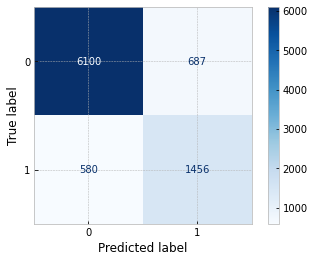

In [679]:
confusion(model_lightGBM,x_test,y_test)

In [491]:
feature_importance(model_lightGBM)

,importance,features
0,496,Hours-per-week
1,452,Age
2,350,Capital
3,274,fnlwgt
4,199,Education-num
5,68,Marital-status_ Married-civ-spouse
6,50,Sex_ Female
7,50,Occupation_ Adm-clerical
8,46,Occupation_ Machine-op-inspct
9,44,Work-class_ Self-emp-not-inc


## Random Forest

In [670]:
model_lr = linear_model.LogisticRegression(random_state=123)
model_lr.fit(X_SMOTE_train, y_SMOTE_train)
y_SMOTE_pred=model_lr.predict_proba(X_SMOTE_train)
train_auc = metrics.roc_auc_score(y_SMOTE_train, y_SMOTE_pred[:,1])
y_pred=model_lr.predict_proba(x_test)
test_auc = metrics.roc_auc_score(y_test, y_pred[:,1])
name='lrmodel'
print('Train: Model: {} | Train AUC: {:.4f}'.format(name, train_auc))
print('Test: Model: {} | Test AUC: {:.4f}'.format(name, test_auc))

Train: Model: lrmodel | Train AUC: 0.9361
Test: Model: lrmodel | Test AUC: 0.8864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [672]:
report(model_lr,x_test,y_test)

ROC AUC score: 0.8863990965045565
Accuracy score: 0.8160489629377763
F1 score: [0.87477818 0.65357524]
Precision score: [0.91820538 0.57795394]
Classification report for classifier LogisticRegression(random_state=123):
              precision    recall  f1-score   support

           0       0.92      0.84      0.87      6787
           1       0.58      0.75      0.65      2036

    accuracy                           0.82      8823
   macro avg       0.75      0.79      0.76      8823
weighted avg       0.84      0.82      0.82      8823




/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3000x2000 with 0 Axes>

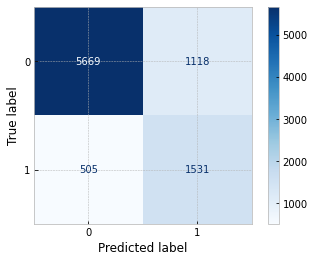

In [680]:
confusion(model_lr,x_test,y_test)

In [495]:
feature_importance(model_rf)

,importance,features
0,0.133,Age
1,0.121,fnlwgt
2,0.108,Hours-per-week
3,0.092,Marital-status_ Married-civ-spouse
4,0.090,Education-num
5,0.052,Relationship_ Husband
6,0.050,Marital-status_ Never-married
7,0.042,Capital
8,0.024,Relationship_ Not-in-family
9,0.024,Relationship_ Own-child


### XGBoost

In [497]:
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_SMOTE_train, y_SMOTE_train)
y_SMOTE_pred=model_xgb.predict_proba(X_SMOTE_train)
train_auc = metrics.roc_auc_score(y_SMOTE_train, y_SMOTE_pred[:,1])
y_pred=model_xgb.predict_proba(x_test)
test_auc = metrics.roc_auc_score(y_test, y_pred[:,1])
name='XGBoost'
print('Train: Model: {} | Train AUC: {:.4f}'.format(name, train_auc))
print('Test: Model: {} | Test AUC: {:.4f}'.format(name, test_auc))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Train: Model: XGBoost | Train AUC: 0.9836
Test: Model: XGBoost | Test AUC: 0.9063


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [500]:
report(model_xgb,x_test,y_test)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ROC AUC score: 0.9063475606173017
Accuracy score: 0.8511844043975972
F1 score: [0.90253136 0.68550898]
Precision score: [0.90948534 0.66900421]
Classification report for classifier XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None):
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6787
           1       0.67      0.70      0.69      2036

    accuracy                           0.85      8823
   macro avg    

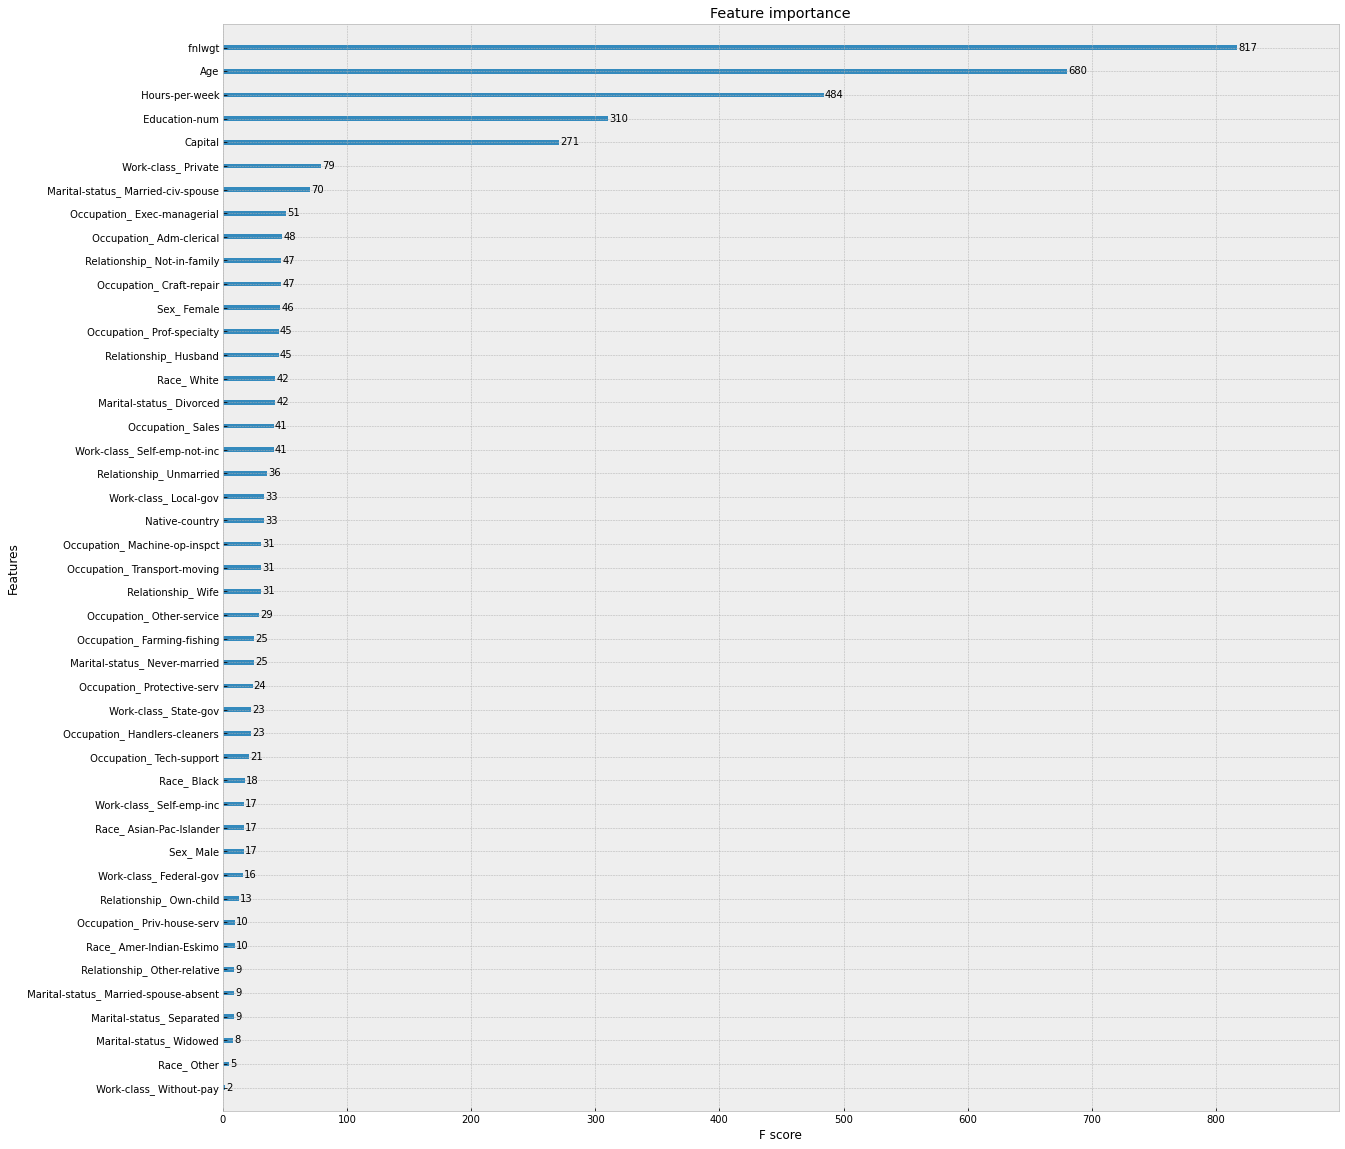

In [501]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(20,20))
plot_importance(model_xgb, ax=ax)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<Figure size 3000x2000 with 0 Axes>

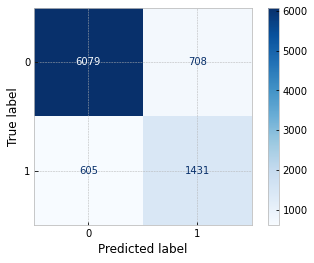

In [681]:
confusion(model_xgb,x_test,y_test)

# Tuning LightGBM

In [664]:
#set estimator
estimator = lgb.LGBMClassifier(random_state=123)

#set parameter
parameters = {
                'num_leaves':[31],
                'max_depth':[20],
                # 'feature_fraction':[0.8],
                'min_gain_to_split':[1],
                'learning_rate':[0.05,0.1],
                'num_iterations':[100,150],
                'max_bin':[300]
                }

#configure the GridSearchCV object
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=True)

# fit the model
grid_search.fit(X_SMOTE_train, y_SMOTE_train)
print(grid_search.best_params_)
best=grid_search.best_estimator_

y_SMOTE_pred=best.predict_proba(X_SMOTE_train)
train_auc = metrics.roc_auc_score(y_SMOTE_train, y_SMOTE_pred[:,1])
y_pred=best.predict_proba(x_test)
test_auc = metrics.roc_auc_score(y_test, y_pred[:,1])
name='lightGBM'
print('Train: Model: {} | Train AUC: {:.4f}'.format(name, train_auc))
print('Test: Model: {} | Test AUC: {:.4f}'.format(name, test_auc))

dictl[str(grid_search.best_params_)]=test_auc

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
{'learning_rate': 0.1, 'max_bin': 300, 'max_depth': 20, 'min_gain_to_split': 1, 'num_iterations': 150, 'num_leaves': 31}
Train: Model: lightGBM | Train AUC: 0.9770
Test: Model: lightGBM | Test AUC: 0.9122


In [653]:
dictl

{"{'feature_fraction': 1, 'learning_rate': 0.1, 'max_bin': 455, 'min_gain_to_split': 0.5, 'num_leaves': 70}": 0.9089937917253688,
 "{'feature_fraction': 1, 'learning_rate': 0.1, 'max_bin': 400, 'min_gain_to_split': 0.5, 'num_leaves': 70}": 0.9092712854199768,
 "{'feature_fraction': 1, 'learning_rate': 0.1, 'max_bin': 400, 'min_gain_to_split': 0.3, 'num_leaves': 80}": 0.9091630234387189,
 "{'feature_fraction': 1, 'max_depth': -1, 'min_gain_to_split': 1, 'num_leaves': 31}": 0.9106971087393182,
 "{'max_depth': -1}": 0.9113867361125785,
 "{'max_depth': 50}": 0.9113867361125785,
 "{'max_depth': 100}": 0.9113867361125785,
 "{'max_depth': 20}": 0.9114575116591496,
 "{'max_depth': 10}": 0.9106154056799329,
 "{'max_depth': 15}": 0.9109844444322224,
 "{'max_depth': 25}": 0.9113867361125785,
 "{'max_bin': 400, 'max_depth': 20}": 0.9108275152167425,
 "{'max_bin': 300, 'max_depth': 20}": 0.9116266710048652,
 "{'max_bin': 250, 'max_depth': 20}": 0.9114568603504388,
 "{'max_bin': 300, 'max_depth': 20

In [666]:
feature_importance(best)

,importance,features
0,788,Hours-per-week
1,666,Age
2,609,fnlwgt
3,521,Capital
4,309,Education-num
5,62,Occupation_ Adm-clerical
6,58,Occupation_ Machine-op-inspct
7,58,Occupation_ Craft-repair
8,54,Occupation_ Other-service
9,52,Occupation_ Transport-moving


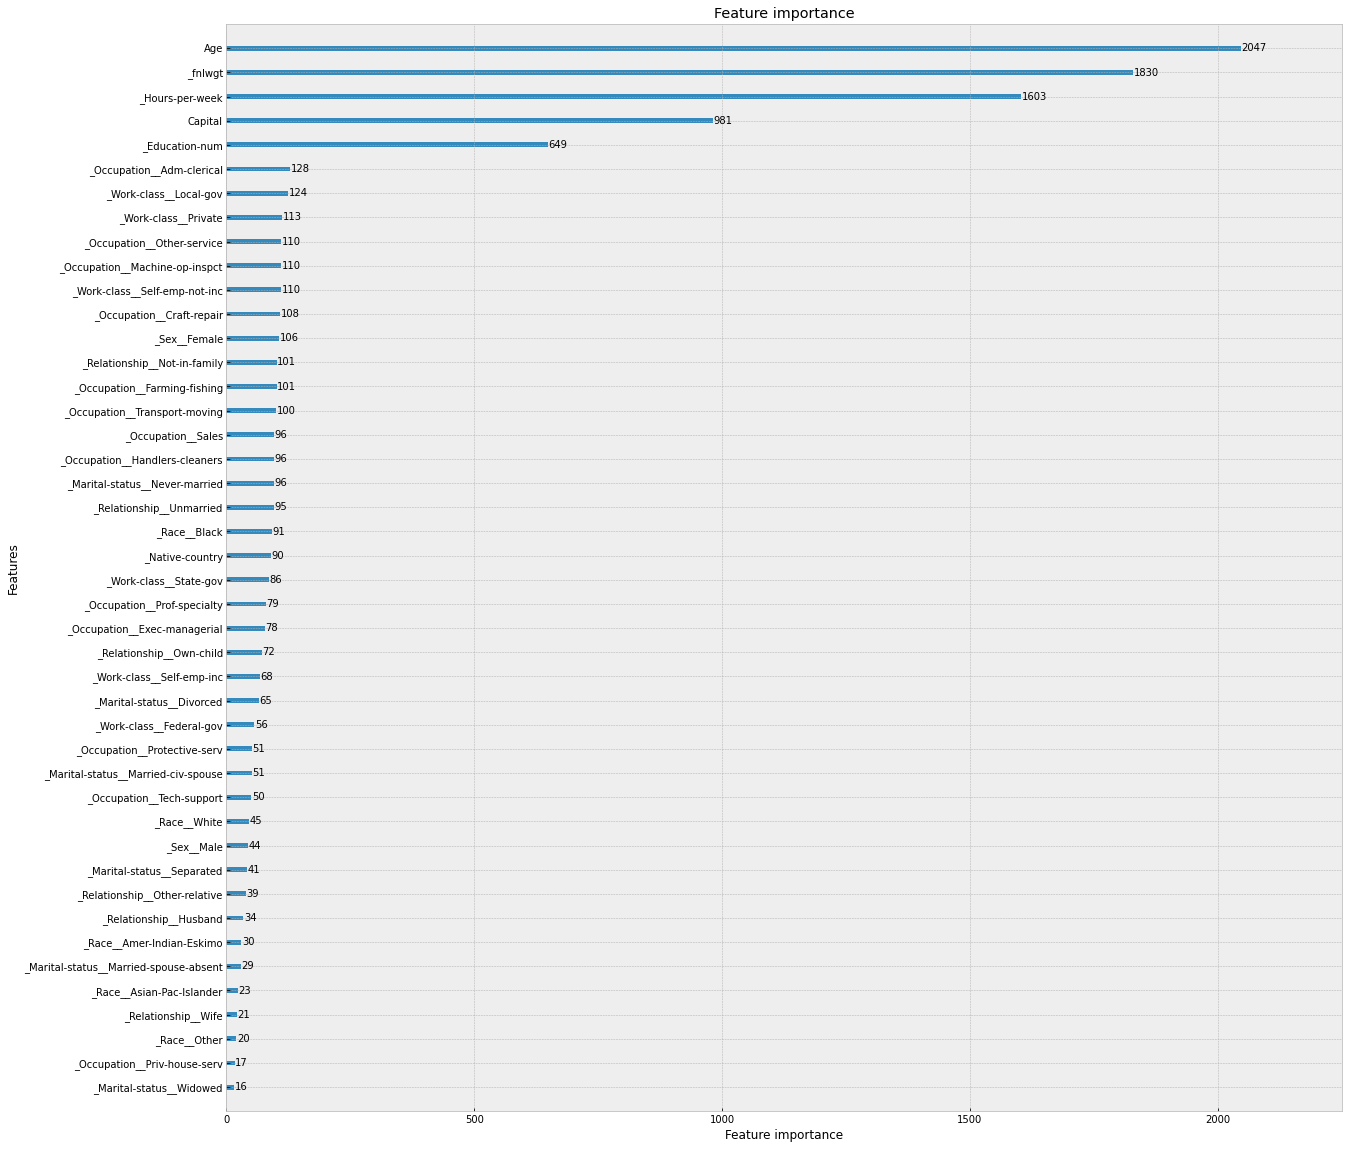

In [416]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(20,20))
plot_importance(best, ax=ax)
plt.show()

In [665]:
report(best,x_test,y_test)

ROC AUC score: 0.91222772039346
Accuracy score: 0.8579848124220787
F1 score: [0.90695775 0.7001675 ]
Precision score: [0.91422156 0.68268782]
Classification report for classifier LGBMClassifier(max_bin=300, max_depth=20, min_gain_to_split=1,
               num_iterations=150, random_state=123):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6787
           1       0.68      0.72      0.70      2036

    accuracy                           0.86      8823
   macro avg       0.80      0.81      0.80      8823
weighted avg       0.86      0.86      0.86      8823




In [667]:
lb=lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
lb.fit(X_SMOTE_train, y_SMOTE_train)

LGBMClassifier(random_state=123)

In [668]:
report(lb,x_test,y_test)

ROC AUC score: 0.9113867361125785
Accuracy score: 0.8563980505496996
F1 score: [0.90591817 0.69681742]
Precision score: [0.91317365 0.67942137]
Classification report for classifier LGBMClassifier(random_state=123):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6787
           1       0.68      0.72      0.70      2036

    accuracy                           0.86      8823
   macro avg       0.80      0.81      0.80      8823
weighted avg       0.86      0.86      0.86      8823


